### Packages 

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
)
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

# **Importing datasets and preprocessing**

In [57]:
Xs_tr_match1 = np.load("../MIMIC_data_handler/numpy_data_c1/Xstatic_train_match1.npy")    
Xs_te_match1 = np.load("../MIMIC_data_handler/numpy_data_c1/Xstatic_test_match1.npy")

y_tr_match1 = np.load("../MIMIC_data_handler/numpy_data_c1/y_train_match1.npy")      
y_te_match1 = np.load("../MIMIC_data_handler/numpy_data_c1/y_test_match1.npy")   

Xs_tr_match2 = np.load("../eICU_data_handler/numpy_data_c2/Xstatic_train_match2.npy")    
Xs_te_match2 = np.load("../eICU_data_handler/numpy_data_c2/Xstatic_test_match2.npy")   

y_tr_match2 = np.load("../eICU_data_handler/numpy_data_c2/y_train_match2.npy")      
y_te_match2 = np.load("../eICU_data_handler/numpy_data_c2/y_test_match2.npy")  

In [58]:
print("Xs_tr_match1:", Xs_tr_match1.shape)
print("Xs_te_match1:", Xs_te_match1.shape)
print("y_tr_match1:", y_tr_match1.shape)
print("y_te_match1:", y_te_match1.shape)

Xs_tr_match1: (27585, 6)
Xs_te_match1: (6897, 6)
y_tr_match1: (27585,)
y_te_match1: (6897,)


In [59]:
print("Xs_tr_match2:", Xs_tr_match2.shape)
print("Xs_te_match2:", Xs_te_match2.shape)
print("y_tr_match2:", y_tr_match2.shape)
print("y_te_match2:", y_te_match2.shape)

Xs_tr_match2: (34137, 6)
Xs_te_match2: (8535, 6)
y_tr_match2: (34137,)
y_te_match2: (8535,)


In [60]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# **Training**

Inspiration from https://github.com/ziyuan-shen/LSTM_MIMICIII/tree/master/Code which took inspiration from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0211057

In [61]:
class StaticMLP(nn.Module):
    def __init__(self, input_size=6, mlp_hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, mlp_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.Linear(mlp_hidden, mlp_hidden//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(mlp_hidden//2, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

In [ ]:
def train_static(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for xs, y in loader:
        xs, y = xs.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(xs)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * xs.size(0)
    return total_loss / len(loader.dataset)

def eval_static(model, loader, criterion, device):
    model.eval()
    total_loss, all_probs, all_labels = 0.0, [], []
    with torch.no_grad():
        for xs, y in loader:
            xs, y = xs.to(device), y.to(device)
            logits = model(xs)
            total_loss += criterion(logits, y).item() * xs.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(y.cpu().numpy())
    probs = np.concatenate(all_probs)
    labels = np.concatenate(all_labels).astype(int)
    roc_auc = roc_auc_score(labels, probs)
    pr_auc = average_precision_score(labels, probs)
    fpr, tpr, _ = roc_curve(labels, probs)
    return total_loss / len(loader.dataset), roc_auc, pr_auc, (fpr, tpr)

def compute_epoch_metrics(model, loader, device):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    with torch.no_grad():
        for xs, y in loader:
            xs, y = xs.to(device), y.to(device)
            logits = model(xs)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_probs.append(probs)
            all_preds.append(preds)
            all_labels.append(y.cpu().numpy())
    probs = np.concatenate(all_probs)
    preds = np.concatenate(all_preds)
    labels = np.concatenate(all_labels).astype(int)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds)
    }

def evaluate_all_metrics(model, loader, criterion, device):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    total_loss = 0.0
    with torch.no_grad():
        for xs, y in loader:
            xs, y = xs.to(device), y.to(device)
            logits = model(xs)
            loss = criterion(logits, y)
            total_loss += loss.item() * xs.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_probs.append(probs)
            all_preds.append(preds)
            all_labels.append(y.cpu().numpy())
    probs = np.concatenate(all_probs)
    preds = np.concatenate(all_preds)
    labels = np.concatenate(all_labels).astype(int)
    return {
        'Accuracy': accuracy_score(labels, preds),
        'Precision': precision_score(labels, preds),
        'Recall': recall_score(labels, preds),
        'F1 Score': f1_score(labels, preds),
        'ROC AUC': roc_auc_score(labels, probs),
        'PR AUC': average_precision_score(labels, probs),
        'Loss': total_loss / len(loader.dataset)
    }

def compute_auc(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for xs, y in loader:
            xs, y = xs.to(device), y.to(device)
            logits = model(xs)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(y.cpu().numpy())
    probs = np.concatenate(all_probs)
    labels = np.concatenate(all_labels).astype(int)
    return roc_auc_score(labels, probs)

In [63]:
# Convert to torch tensors
X1_tr_t = torch.from_numpy(Xs_tr_match1) 
y1_tr_t = torch.from_numpy(y_tr_match1).float()
X1_te_t = torch.from_numpy(Xs_te_match1)
y1_te_t = torch.from_numpy(y_te_match1).float()

X2_tr_t = torch.from_numpy(Xs_tr_match2)
y2_tr_t = torch.from_numpy(y_tr_match2).float()
X2_te_t = torch.from_numpy(Xs_te_match2)
y2_te_t = torch.from_numpy(y_te_match2).float()

# TensorDataset for each client
train_ds1 = TensorDataset(X1_tr_t, y1_tr_t)
test_ds1 = TensorDataset(X1_te_t, y1_te_t)

train_ds2 = TensorDataset(X2_tr_t, y2_tr_t)
test_ds2 = TensorDataset(X2_te_t, y2_te_t)

# Dataloders
train_loader1 = DataLoader(train_ds1, batch_size=64, shuffle=True,  num_workers=0)
test_loader1 = DataLoader(test_ds1,  batch_size=64, shuffle=False, num_workers=0)

train_loader2 = DataLoader(train_ds2, batch_size=64, shuffle=True,  num_workers=0)
test_loader2 = DataLoader(test_ds2,  batch_size=64, shuffle=False, num_workers=0)

### MIMIC

In [64]:
counts1 = np.bincount(y_tr_match1.astype(int))
pos_weight1 = torch.tensor(counts1[0]/counts1[1], dtype=torch.float32, device=device)

model1 = StaticMLP(input_size=Xs_tr_match1.shape[1]).to(device)
criterion1 = nn.BCEWithLogitsLoss(pos_weight=pos_weight1)
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4, weight_decay=1e-5)

history1 = {'train_loss':[], 'test_roc_auc':[], 'test_pr_auc':[], 'train_auc':[], 'test_auc':[]}
roc_history1 = {}

max_epochs = 20
for epoch in range(1, max_epochs+1):
    tr_loss = train_static(model1, train_loader1, optimizer1, criterion1, device)
    val_loss, roc_auc, pr_auc, (fpr, tpr) = eval_static(model1, test_loader1, criterion1, device)
    train_auc = compute_auc(model1, train_loader1, device)
    epoch_metrics = compute_epoch_metrics(model1, test_loader1, device)

    history1['train_loss'].append(tr_loss)
    history1['test_roc_auc'].append(roc_auc)
    history1['test_pr_auc'].append(pr_auc)
    history1['train_auc'].append(train_auc)
    history1['test_auc'].append(roc_auc)
    for k, v in epoch_metrics.items():
        history1.setdefault(k, []).append(v)

    roc_history1[epoch] = (fpr, tpr)
    print(f"[Client1 | Epoch {epoch}] Train loss {tr_loss:.4f} | Train AUC {train_auc:.3f} | Test AUC {roc_auc:.3f} | PR AUC {pr_auc:.3f}")

[Client1 | Epoch 1] Train loss 0.0915 | Train AUC 0.674 | Test AUC 0.656 | PR AUC 0.959
[Client1 | Epoch 2] Train loss 0.0895 | Train AUC 0.677 | Test AUC 0.656 | PR AUC 0.959
[Client1 | Epoch 3] Train loss 0.0890 | Train AUC 0.678 | Test AUC 0.658 | PR AUC 0.959
[Client1 | Epoch 4] Train loss 0.0887 | Train AUC 0.680 | Test AUC 0.660 | PR AUC 0.960
[Client1 | Epoch 5] Train loss 0.0890 | Train AUC 0.682 | Test AUC 0.660 | PR AUC 0.960
[Client1 | Epoch 6] Train loss 0.0889 | Train AUC 0.682 | Test AUC 0.663 | PR AUC 0.960
[Client1 | Epoch 7] Train loss 0.0888 | Train AUC 0.683 | Test AUC 0.661 | PR AUC 0.960
[Client1 | Epoch 8] Train loss 0.0887 | Train AUC 0.684 | Test AUC 0.663 | PR AUC 0.960
[Client1 | Epoch 9] Train loss 0.0883 | Train AUC 0.685 | Test AUC 0.664 | PR AUC 0.960
[Client1 | Epoch 10] Train loss 0.0883 | Train AUC 0.685 | Test AUC 0.662 | PR AUC 0.960
[Client1 | Epoch 11] Train loss 0.0885 | Train AUC 0.686 | Test AUC 0.662 | PR AUC 0.960
[Client1 | Epoch 12] Train los

### eICU

In [65]:
counts2 = np.bincount(y_tr_match2.astype(int))
pos_weight2 = torch.tensor(counts2[0]/counts2[1], dtype=torch.float32, device=device)

model2 = StaticMLP(input_size=Xs_tr_match2.shape[1]).to(device)
criterion2 = nn.BCEWithLogitsLoss(pos_weight=pos_weight2)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-4, weight_decay=1e-5)

history2 = {'train_loss':[], 'test_roc_auc':[], 'test_pr_auc':[], 'train_auc':[], 'test_auc':[]}
roc_history2 = {}

for epoch in range(1, max_epochs+1):
    tr_loss = train_static(model2, train_loader2, optimizer2, criterion2, device)
    test_loss, roc_auc, pr_auc, (fpr, tpr) = eval_static(model2, test_loader2, criterion2, device)
    train_auc = compute_auc(model2, train_loader2, device)
    epoch_metrics = compute_epoch_metrics(model2, test_loader2, device)

    history2['train_loss'].append(tr_loss)
    history2['test_roc_auc'].append(roc_auc)
    history2['test_pr_auc'].append(pr_auc)
    history2['train_auc'].append(train_auc)
    history2['test_auc'].append(roc_auc)
    for k, v in epoch_metrics.items():
        history2.setdefault(k, []).append(v)

    roc_history2[epoch] = (fpr, tpr)
    print(f"[Client2 | Epoch {epoch}] Train loss {tr_loss:.4f} | Train AUC {train_auc:.3f} | Test AUC {roc_auc:.3f} | PR AUC {pr_auc:.3f}")

[Client2 | Epoch 1] Train loss 0.0973 | Train AUC 0.619 | Test AUC 0.608 | PR AUC 0.950
[Client2 | Epoch 2] Train loss 0.0963 | Train AUC 0.620 | Test AUC 0.607 | PR AUC 0.950
[Client2 | Epoch 3] Train loss 0.0964 | Train AUC 0.621 | Test AUC 0.607 | PR AUC 0.950
[Client2 | Epoch 4] Train loss 0.0959 | Train AUC 0.621 | Test AUC 0.606 | PR AUC 0.950
[Client2 | Epoch 5] Train loss 0.0964 | Train AUC 0.622 | Test AUC 0.606 | PR AUC 0.950
[Client2 | Epoch 6] Train loss 0.0961 | Train AUC 0.623 | Test AUC 0.606 | PR AUC 0.950
[Client2 | Epoch 7] Train loss 0.0962 | Train AUC 0.624 | Test AUC 0.606 | PR AUC 0.950
[Client2 | Epoch 8] Train loss 0.0962 | Train AUC 0.623 | Test AUC 0.605 | PR AUC 0.950
[Client2 | Epoch 9] Train loss 0.0961 | Train AUC 0.624 | Test AUC 0.605 | PR AUC 0.950
[Client2 | Epoch 10] Train loss 0.0962 | Train AUC 0.625 | Test AUC 0.606 | PR AUC 0.950
[Client2 | Epoch 11] Train loss 0.0959 | Train AUC 0.625 | Test AUC 0.606 | PR AUC 0.950
[Client2 | Epoch 12] Train los

# **Evaluations**

In [67]:
metrics1 = evaluate_all_metrics(model1, test_loader1, criterion1, device)
metrics2 = evaluate_all_metrics(model2, test_loader2, criterion2, device)
metrics_df = pd.DataFrame([metrics1, metrics2], index=["Client 1 (MIMIC)", "Client 2 (eICU)"])
print(metrics_df)

                  Accuracy  Precision  Recall  F1 Score   ROC AUC    PR AUC  \
Client 1 (MIMIC)  0.068581        0.0     0.0       0.0  0.660764  0.959823   
Client 2 (eICU)   0.071470        0.0     0.0       0.0  0.605844  0.949754   

                      Loss  
Client 1 (MIMIC)  2.669049  
Client 2 (eICU)   1.593335  


# **Plotting**

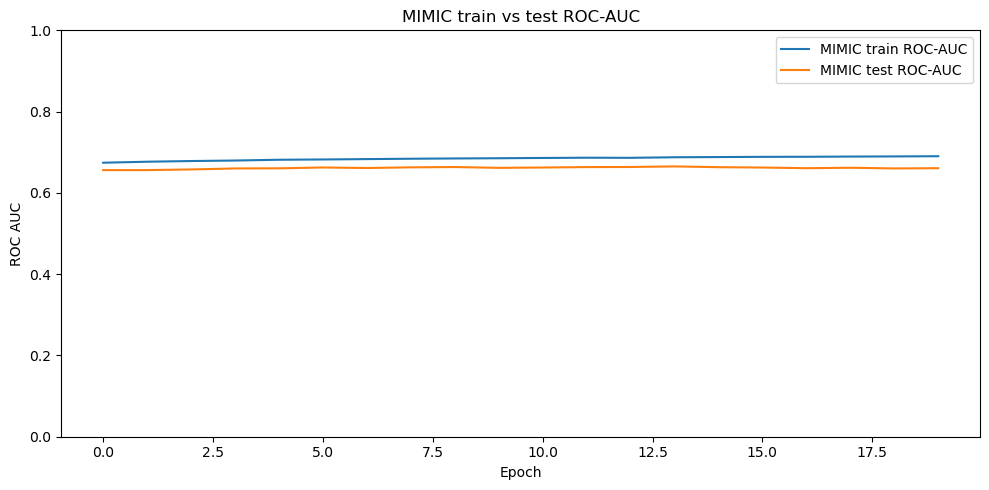

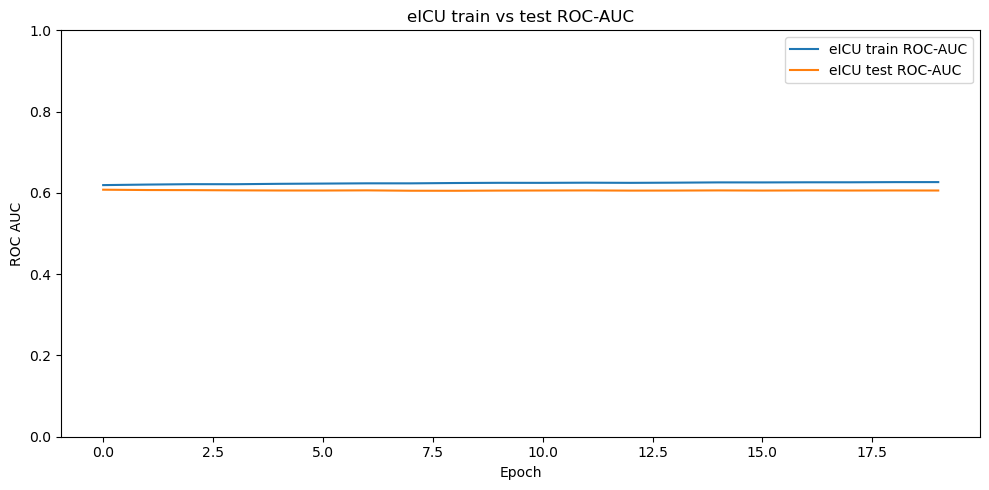

In [73]:
plt.figure(figsize=(10, 5))
plt.plot(history1["train_auc"], label="MIMIC train ROC-AUC")
plt.plot(history1["test_auc"], label="MIMIC test ROC-AUC")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.title("MIMIC train vs test ROC-AUC")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history2["train_auc"], label="eICU train ROC-AUC")
plt.plot(history2["test_auc"], label="eICU test ROC-AUC")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.title("eICU train vs test ROC-AUC")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

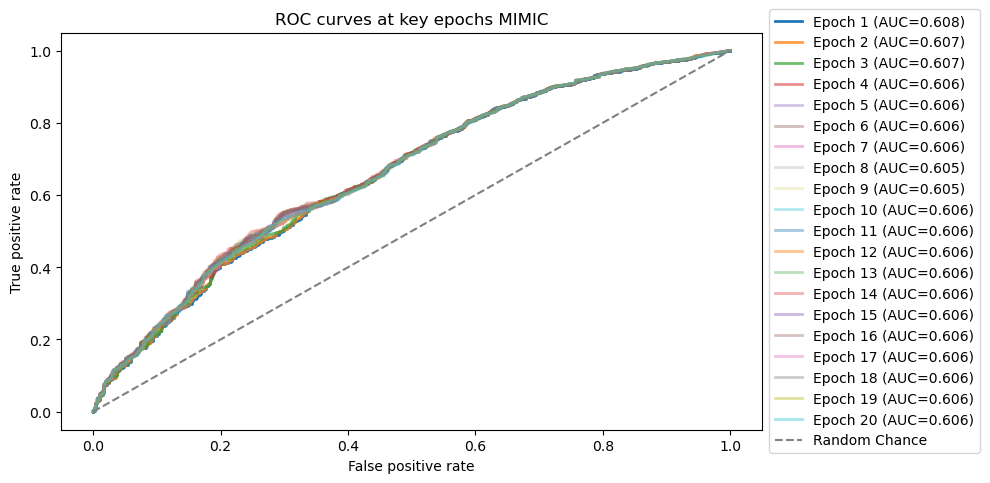

In [ ]:
plt.figure(figsize=(10, 5))

plotted_aucs = []
for ep in sorted(roc_history1.keys()):
    if 0 <= ep - 1 < len(history2["test_roc_auc"]):
        plotted_aucs.append(history2["test_roc_auc"][ep - 1])

# We plot where all lines are the same color, but the higher the AUC, the more opaque the line
if plotted_aucs: 
    min_auc = min(plotted_aucs)
    max_auc = max(plotted_aucs)
    min_alpha = 0.2 
    max_alpha = 1.0
else: 
    min_auc, max_auc = 0, 1 
    min_alpha, max_alpha = 0.2, 1.0


for ep, (fpr, tpr) in sorted(roc_history1.items()):
    current_alpha = min_alpha 
    if 0 <= ep - 1 < len(history2["test_roc_auc"]):
        auc_test = history2["test_roc_auc"][ep-1]
        
        if max_auc == min_auc: 
            current_alpha = max_alpha
        else:
            # Scale AUC to be between 0 and 1
            normalized_auc = (auc_test - min_auc) / (max_auc - min_auc)
            # Scale to be between min_alpha and max_alpha
            current_alpha = min_alpha + (normalized_auc * (max_alpha - min_alpha))
        
        label_text = f"Epoch {ep} (AUC={auc_test:.3f})"
    else:
        # Fallback if epoch number is out of bounds
        auc_test = "N/A" # For the label
        label_text = f"Epoch {ep} (AUC=N/A)"

    plt.plot(fpr, tpr, label=label_text, alpha=current_alpha, linewidth=2)

plt.plot([0,1], [0,1], "--", color="gray", label="Random Chance")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves at key epochs MIMIC") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.tight_layout()
plt.show()

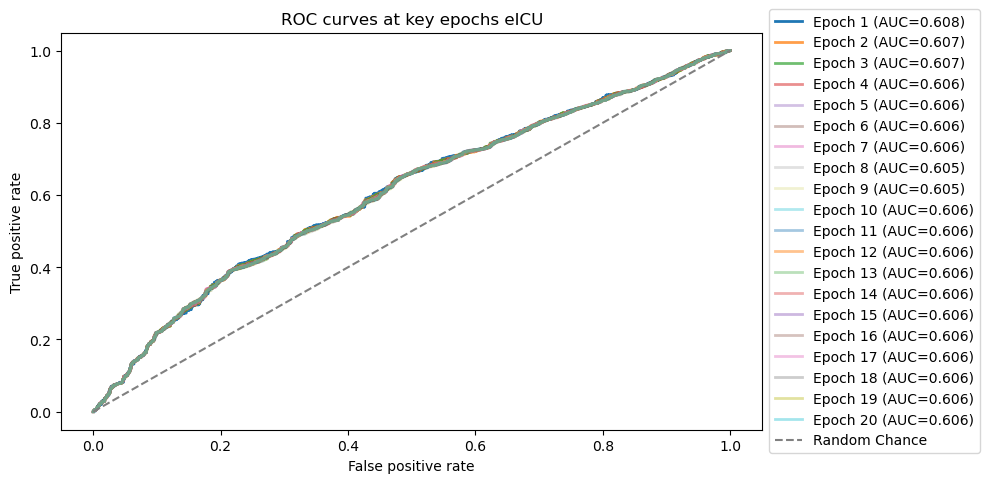

In [ ]:
plt.figure(figsize=(10, 5))

plotted_aucs = []
for ep in sorted(roc_history2.keys()):
    if 0 <= ep - 1 < len(history2["test_roc_auc"]):
        plotted_aucs.append(history2["test_roc_auc"][ep - 1])

# We plot where all lines are the same color, but the higher the AUC, the more opaque the line
if plotted_aucs: 
    min_auc = min(plotted_aucs)
    max_auc = max(plotted_aucs)
    min_alpha = 0.2 
    max_alpha = 1.0
else: 
    min_auc, max_auc = 0, 1 
    min_alpha, max_alpha = 0.2, 1.0


for ep, (fpr, tpr) in sorted(roc_history2.items()):
    current_alpha = min_alpha 
    if 0 <= ep - 1 < len(history2["test_roc_auc"]):
        auc_test = history2["test_roc_auc"][ep-1]
        
        if max_auc == min_auc: # Avoid division by zero if all AUCs are the same
            current_alpha = max_alpha
        else:
            # Scale AUC to be between 0 and 1
            normalized_auc = (auc_test - min_auc) / (max_auc - min_auc)
            current_alpha = min_alpha + (normalized_auc * (max_alpha - min_alpha))
        
        label_text = f"Epoch {ep} (AUC={auc_test:.3f})"
    else:
        # Fallback if epoch number is out of bounds
        auc_test = "N/A" # For the label
        label_text = f"Epoch {ep} (AUC=N/A)"

    plt.plot(fpr, tpr, label=label_text, alpha=current_alpha, linewidth=2)

plt.plot([0,1], [0,1], "--", color="gray", label="Random Chance")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves at key epochs eICU") 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Keep legend outside the plot
plt.tight_layout()
plt.show()